<a href="https://colab.research.google.com/github/coinsbarboss/brian/blob/master/1_StyleGAN_Encoder_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part I: Encoding images into StyleGAN's latent space

![alt text](https://miro.medium.com/max/1280/0*eeFaGLx96mlbQcrK.gif)

In [1]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

1.15.0


In [2]:
!rm -rf sample_data
!git clone https://github.com/pbaylies/stylegan-encoder
!git clone https://github.com/robertluxemburg/stylegan2encoder.git
!gdown 'https://drive.google.com/uc?id=1igxv6ZP4TFGe_392B-qnSqXnglTKH5yo'
!mkdir -p /content/stylegan2encoder/cache
!mv /content/stylegan2-ffhq-config-f.pkl /content/stylegan2encoder/cache
!gdown 'https://drive.google.com/uc?id=1aT59NFy9-bNyXjDuZOTMl0qX0jmZc6Zb'
!mkdir /content/stylegan-encoder/data
!mv finetuned_resnet.h5 /content/stylegan-encoder/data
!rm -rf /content/stylegan-encoder/generated_images /content/stylegan-encoder/latent_representations
!rm -rf /content/stylegan-encoder/aligned_images /content/stylegan-encoder/raw_images /content/stylegan-encoder/encode_images.py
!mkdir /content/stylegan-encoder/aligned_images /content/stylegan-encoder/raw_images
!gdown 'https://drive.google.com/uc?id=1S8IniJ9_9D2ks53QV86SVXdcs5GfrZ8x'
!mv /content/encode_images.py /content/stylegan-encoder/
!echo "UPLOAD RAW IMAGES NOW!"

Cloning into 'stylegan-encoder'...
remote: Enumerating objects: 483, done.
remote: Total 483 (delta 0), reused 0 (delta 0), pack-reused 483
Receiving objects: 100% (483/483), 12.78 MiB | 5.71 MiB/s, done.
Resolving deltas: 100% (267/267), done.
Cloning into 'stylegan2encoder'...
remote: Enumerating objects: 108, done.
remote: Total 108 (delta 0), reused 0 (delta 0), pack-reused 108
Receiving objects: 100% (108/108), 4.47 MiB | 2.98 MiB/s, done.
Resolving deltas: 100% (28/28), done.
Downloading...
From: https://drive.google.com/uc?id=1igxv6ZP4TFGe_392B-qnSqXnglTKH5yo
To: /content/stylegan2-ffhq-config-f.pkl
382MB [00:01, 196MB/s]
Downloading...
From: https://drive.google.com/uc?id=1aT59NFy9-bNyXjDuZOTMl0qX0jmZc6Zb
To: /content/finetuned_resnet.h5
330MB [00:03, 87.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1S8IniJ9_9D2ks53QV86SVXdcs5GfrZ8x
To: /content/encode_images.py
100% 15.3k/15.3k [00:00<00:00, 12.1MB/s]
UPLOAD RAW IMAGES NOW!


In [3]:
cd stylegan-encoder

/content/stylegan-encoder


In [4]:
!python align_images.py raw_images/ aligned_images/ --output_size=1024

Using TensorFlow backend.
64045056/64040097 [==============================] - 6s 0us/step
Aligning 00173.png ...
Getting landmarks...
Starting face alignment...
Wrote result aligned_images/00173_01.png


In [5]:
import os
print("aligned_images contains %d images ready for encoding!" %len(os.listdir('aligned_images/')))

aligned_images contains 1 images ready for encoding!


In [31]:
!python encode_images.py --batch_size=2 --optimizer=ggt --lr=0.02 --decay_rate=0.85 --decay_steps=6 --face_mask=False --iterations=1000 --early_stopping=True --early_stopping_threshold=0.05 --average_best_loss=0.5 --use_lpips_loss=0 --use_discriminator_loss=0 --output_video=True aligned_images generated_images latent_representations
print("\n************ Latent code optimization finished! ***************")




Using TensorFlow backend.










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








0it [00:00, ?it/s]Loading ResNet Model:






  0% 0/1000 [00:00<?, ?it/s]WARNING:tensorflow:
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().

00173_01: loss 125.3725; lr 0.0200:   0% 0/1000 [00:09<?, ?it/s]
00173_01: loss 125.3725; lr 0.0200:   0% 1/1000 [00:10<2:57:00, 10.63s/it]
00173_01: loss 124.6628; lr 0.0200:   0% 1/1000 [00:10<2:57:00, 10.63s/it]
00173_01: loss 124.6628; lr 0.0200:   0% 2/1000 [00:11<2:05:40,  7.

## Showtime!
### Let's load the StyleGAN network into memory:

In [32]:
import dnnlib, pickle
import dnnlib.tflib as tflib
tflib.init_tf()
synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), minibatch_size=1)

model_dir = 'cache/'
model_path = [model_dir+f for f in os.listdir(model_dir) if 'stylegan-ffhq' in f][0]
print("Loading StyleGAN model from %s..." %model_path)

with dnnlib.util.open_url(model_path) as f:
  generator_network, discriminator_network, averaged_generator_network = pickle.load(f)
  
print("StyleGAN loaded & ready for sampling!")

Loading StyleGAN model from cache/263e666dc20e26dcbfa514733c1d1f81_karras2019stylegan-ffhq-1024x1024.pkl...
StyleGAN loaded & ready for sampling!


In [0]:
def generate_images(generator, latent_vector, z = True):
    batch_size = latent_vector.shape[0]
    
    if z: #Start from z: run the full generator network
        return generator.run(latent_vector.reshape((batch_size, 512)), None, randomize_noise=False, **synthesis_kwargs)
    else: #Start from w: skip the mapping network
        return generator.components.synthesis.run(latent_vector.reshape((batch_size, 18, 512)), randomize_noise=False, **synthesis_kwargs)

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_imgs(model, rows, columns):
  for i in range(rows):
    f, axarr = plt.subplots(1,columns, figsize = (20,8))
    for j in range(columns):
      img = generate_images(model, np.random.randn(1,512), z = True)[0]
      axarr[j].imshow(img)
      axarr[j].axis('off')
      axarr[j].set_title('Resolution: %s' %str(img.shape))
    plt.show()

## Let's plot some random StyleGAN samples:

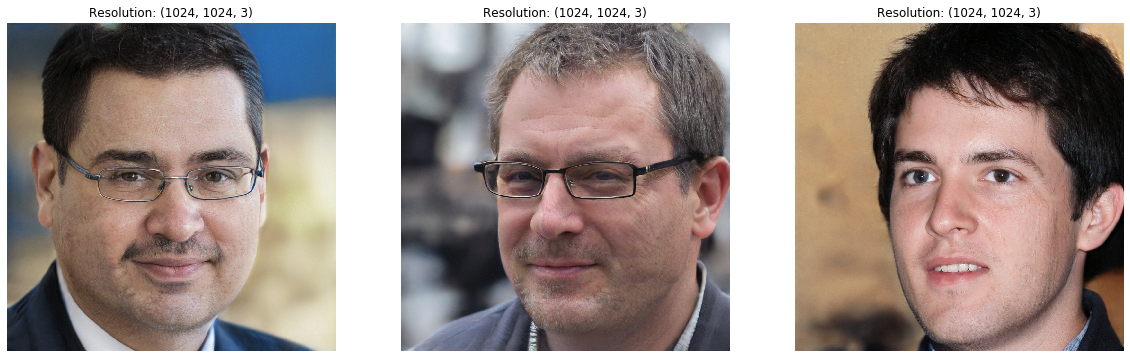

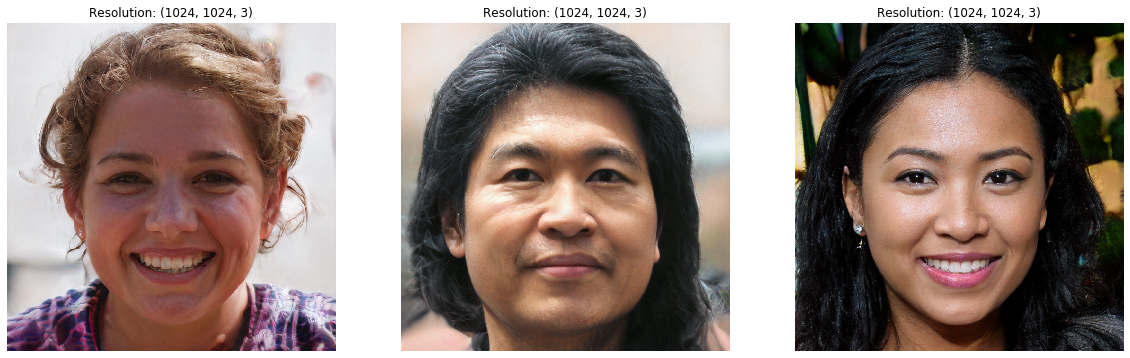

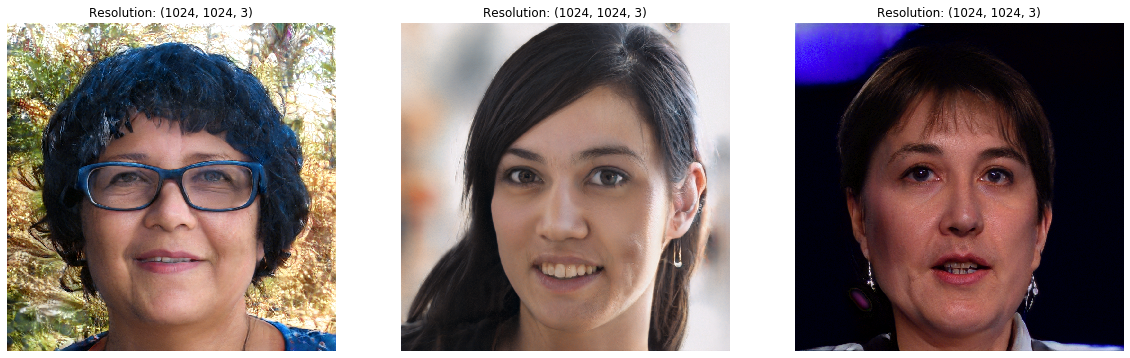

In [35]:
import numpy as np
plot_imgs(averaged_generator_network, 3, 3)

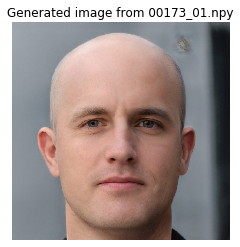

In [36]:
import numpy as np

for f in sorted(os.listdir('latent_representations')):
  w = np.load('latent_representations/' + f).reshape((1,18,-1))
  img = generate_images(averaged_generator_network, w, z = False)[0]
  plt.imshow(img)
  plt.axis('off')
  plt.title("Generated image from %s" %f)
  plt.show()

## Let's compare our encoded samples with the original ones:

In [16]:
ls -al raw_images/

total 3752
drwxr-xr-x  2 root root    4096 Jan  9 08:20 ./
drwxr-xr-x 18 root root    4096 Jan  9 08:23 ../
-rw-r--r--  1 root root 3830178 Jan  9 08:20 00173.png


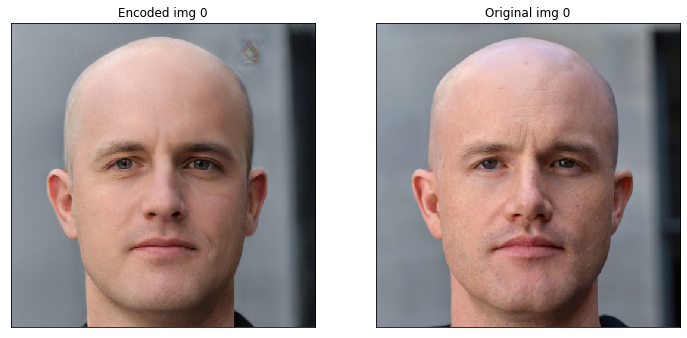

In [37]:
import os
import matplotlib.pyplot as plt
import PIL.Image
from PIL import Image
from PIL import ImageFilter

def plot_two_images(img1,img2, img_id, fs = 12):
  f, axarr = plt.subplots(1,2, figsize=(fs,fs))
  axarr[0].imshow(img1)
  axarr[0].title.set_text('Encoded img %d' %img_id)
  axarr[1].imshow(img2)
  axarr[1].title.set_text('Original img %d' %img_id)
  plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
  plt.show()

def display_sbs(folder1, folder2, res = 256):
  if folder1[-1] != '/': folder1 += '/'
  if folder2[-1] != '/': folder2 += '/'
    
  imgs1 = sorted([f for f in os.listdir(folder1) if '.png' in f])
  imgs2 = sorted([f for f in os.listdir(folder2) if '.png' in f])
  if len(imgs1)!=len(imgs2):
    print("Found different amount of images in aligned vs raw image directories. That's not supposed to happen...")
  
  for i in range(len(imgs1)):
    img1 = Image.open(folder1+imgs1[i]).resize((res,res))
    img2 = Image.open(folder2+imgs2[i]).resize((res,res))
    plot_two_images(img1,img2, i)
    print("")
     
display_sbs('generated_images/', 'aligned_images/', res = 512)

In [0]:
good_images = [0]  #Change these numbers to pick out latents that worked well (see the image plots)

## Save these latent vectors to disk:

In [39]:
import numpy as np
latents = sorted(os.listdir('latent_representations'))

out_file = '/content/output_vectors.npy'

final_w_vectors = []
for img_id in good_images:
  w = np.load('latent_representations/' + latents[img_id])
  final_w_vectors.append(w)

final_w_vectors = np.array(final_w_vectors)
np.save(out_file, final_w_vectors)
print("%d latent vectors of shape %s saved to %s!" %(len(good_images), str(w.shape), out_file))

1 latent vectors of shape (18, 512) saved to /content/output_vectors.npy!
